# Lab4 Intro
Now that you have classified the Voice of Customers into categories in the previous experiment, you can use Generative AI techniques to write analysis report for you further.

### Your objectives are:

- Explore the statistical results of classification
- Write a summary analysis report
- Tuning the prompt instruction to enhance the report

## 1. Install dependencies

In [ ]:
!pip install -Uq boto3 langchain==0.2.16 langchain_aws==0.1.17 pandas openpyxl termcolor

## 2. Initialize Bedrock model using LangChain

We will continue to use Amazon Titan Model to help generate analysis for the result. Different from Lab 1, here we apply the ChatBedrockConverse object which provides a unified conversational interface for Bedrock models.
- We use [Langchain](https://www.langchain.com/) SDK to build the application
- Initialize a ChatBedrockConverse object with Amzon Titan Text model with the model id "amazon.titan-text-premier-v1:0"

#### Use Olympus

In [ ]:
import boto3
import json
from botocore.exceptions import ClientError
import dotenv
import os
dotenv.load_dotenv()

from typing import Any, AsyncIterator, Dict, Iterator, List, Optional

from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import BaseChatModel, SimpleChatModel
from langchain_core.messages import AIMessageChunk, BaseMessage, HumanMessage,AIMessage,SystemMessage
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.runnables import run_in_executor
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate


class ChatModelOly(BaseChatModel):

    model_name: str
    br_runtime : Any = None
    ak: str = None
    sk: str = None
    region:str = None

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:

        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
            
                                              )

            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.5)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}


        # Send the message.
        response = self.br_runtime.converse(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        output_message = response['output']['message']

        message = AIMessage(
            content=output_message['content'][0]['text'],
            additional_kwargs={},  # Used to add additional payload (e.g., function calling request)
            response_metadata={  # Use for response metadata
                **response['usage']
            },
        )
        generation = ChatGeneration(message=message)
        return ChatResult(generations=[generation])


    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
            
                                              )

            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.5)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}

        # Send the message.
        streaming_response = self.br_runtime.converse_stream(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        # Extract and print the streamed response text in real-time.
        for event in streaming_response["stream"]:
            if "contentBlockDelta" in event:
                text = event["contentBlockDelta"]["delta"]["text"]
                # print(text, end="")
                chunk = ChatGenerationChunk(message=AIMessageChunk(content=[{"type":"text","text":text}]))

                if run_manager:
                    # This is optional in newer versions of LangChain
                    # The on_llm_new_token will be called automatically
                    run_manager.on_llm_new_token(text, chunk=chunk)

                yield chunk
            if 'metadata' in event:
                metadata = event['metadata']
                # Let's add some other information (e.g., response metadata)
                chunk = ChatGenerationChunk(
                    message=AIMessageChunk(content=[], response_metadata={**metadata})
                )
                if run_manager:

                    run_manager.on_llm_new_token(text, chunk=chunk)
                yield chunk

    @property
    def _llm_type(self) -> str:
        """Get the type of language model used by this chat model."""
        return "echoing-chat-model-advanced"

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        """Return a dictionary of identifying parameters.

        This information is used by the LangChain callback system, which
        is used for tracing purposes make it possible to monitor LLMs.
        """
        return {
            "model_name": self.model_name,
        }

llm = ChatModelOly(model_name="amazon.olympus-pro-v1:0",
                     ak=os.environ['ak'],
                     sk=os.environ['sk'],
                    region=os.environ['region']
                    )

#### Use Titan

In [14]:
from langchain_aws import ChatBedrock,ChatBedrockConverse
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser,JsonOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate

model_id = "amazon.titan-text-premier-v1:0" 

llm = ChatBedrockConverse(
    model=model_id,
    temperature=0.1,
    max_tokens=3000,
)

- test run

In [10]:
messages = [
    ("human", "translate to french: I love programming."),
]

In [11]:
for chunk in llm.stream(messages):
    if chunk.content and chunk.content[0].get('type') == 'text':
        print(chunk.content[0]['text'],end='',flush=True)

J'adore la programmation.

If you want a more formal translation, you could say: "J'aime programmer."

Both translations convey the idea that you love programming, but the first one is more expressive and informal, while the second one is more straightforward and formal.

## 3. Load the VOC classification results data

At the end of Lab 3, we saved the classified results data into result_lab_3.csv file. To begin our analysis, we first need to load this results data and review its contents.

- Load the classification result data

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

In [13]:
raw_data = pd.read_csv('result_lab_3.csv')

- Use columns 'id','summary','reason','predict_label' 

For analysis purpose, we only need data from column 'summary', 'reason', and 'predict_label'. Execute the code below to retrieve these columns data and rename the column 'predict_label' to 'category'.

In [14]:
results = raw_data[['summary','reason','predict_label']].rename(columns={'predict_label':'category'})
results

,summary,reason,category
0,"'After switching to a new operating system, my...",The user mentions that their phone is no longe...,charging failure
1,The phone's battery health has dropped to 95% ...,The user mentions a decrease in battery health...,abnormal battery health
2,The user expresses concern about the rapid dec...,The user's concern about the battery health de...,abnormal battery health
3,The camera quality of the smartphone is disapp...,The user expresses dissatisfaction with the ca...,camera color deviation
4,"The update speed of this phone is slow, and it...",The user expresses concern about the slow upda...,slow update
...,...,...,...
195,"The phone's screen is less responsive, making ...",The user describes the phone's screen as less ...,unresponsive screen
196,"'After the recent software update, my device h...",The user mentions that their device has shut d...,"automatic restart, shutdown"
197,'Major software updates cause issues for older...,Users report SIM card detection issues after u...,sim card not detected
198,The user's phone has been getting slower and s...,The user mentions that their phone is getting ...,high storage usage


## 4. A simple summary report

We have defined a simple system prompt and user prompt to instruct Amazon Titan model to generate a analysis report. The results data will be incorporated into the prompt as a variable, allowing the model to access and utilize this information in its report generation.

### 4.1 Define system prompt and user prompt template

In [15]:
user = """
You are a data analysis expert in the retail industry. 
Your task is to analyze the given data and write a narrative summary analysis report.
Follow these instructions:

<instructions>
- Transform the data into natural language, including all key data points as much as possible
- Only provide the final narrative report, do not show any intermediate analysis steps or processes
- Give insights and interpretations about the data in your narrative
</instructions>

Here is the tabular data in json to analyze:
<data>
{tabular}
</data>

Please summarize the data in a narrative report format, following the instructions above.
"""

- Create a langchain chat template

In [16]:
prompt_simple = ChatPromptTemplate([
    ('user',user),
    ])
chain = prompt_simple | llm | StrOutputParser()

### 4.2 Generate the report
- convert the tabular data to json string and pass them to llm

In [17]:
response = ''
for chunk in chain.stream({"tabular":results.to_json()}):
    print(colored(chunk,"green"),end='',flush=True)
    response += chunk

### Narrative Summary Analysis Report

The data presents a comprehensive view of consumer experiences and issues related to various electronic devices, including smartphones, tablets, and laptops. The analysis reveals several key trends and recurring problems that users have encountered.

**Charging and Battery Issues:** A significant number of users have reported difficulties with charging their devices. Some phones are no longer able to charge after operating system updates, while others experience rapid battery drain, necessitating frequent charging. Overheating during charging is also a common complaint, with some devices becoming excessively hot and even shutting down automatically.

**Software and Update Problems:** Software updates have been a source of frustration for many users. Issues include failed updates, prolonged update processes, and post-update complications such as data loss, app crashes, and system instability. Some users have experienced automatic restarts and shutd

## 5. Advanced version of report

The example provided above is a basic demonstration of the analysis generation capabilities of a Large Language Model. Now let's craft the prompt to generate a more comprehensize, concise, and detailed version of report.

The prompt provided below are much more detailed and contains steps-by-steps instruction and clear structure that can guide the LLM to generate a report rich in information. Additionally, we have supplied the LLM with statistical data, specifically the summary numbers of comments by category, to provide further context and enhance the depth of the analysis in the report.

- Add formation instruction and statistic data to enhance the report

- Let's stat the number of comments by categories

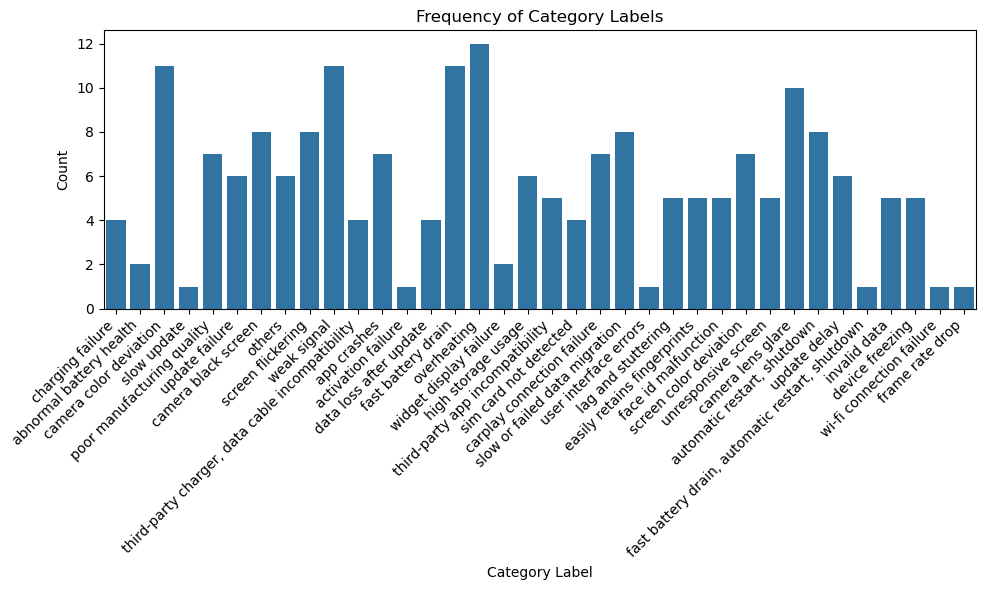

,summary
category,
abnormal battery health,2
activation failure,1
app crashes,7
"automatic restart, shutdown",8
camera black screen,8
camera color deviation,11
camera lens glare,10
carplay connection failure,7
charging failure,4


In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=results[['category']])
plt.title('Frequency of Category Labels')
plt.xlabel('Category Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

statistic_label = results.pivot_table(index='category',aggfunc='count')
statistic_label[['summary']]

### 5.1 Define system prompt and user prompt template
- we add instruction to generate report in certain content agenda as:
```markdown
# Executive Summary
Provide a brief overview of the report, summarizing key findings, conclusions, and recommendations. This section should be concise, allowing readers to grasp the main points quickly.

# Data Presentation
Data Overview: Provide a summary of the datasets used, including key metrics and attributes.
Key Performance Indicators (KPIs): Highlight the KPIs that are critical to the analysis.

# Findings
Present the results of the analysis in a structured manner:
Descriptive Statistics: Summarize the main characteristics of the data.
Trends and Patterns: Discuss any significant trends or patterns identified.
Comparative Analysis: If applicable, compare different datasets or time periods.

# Discussion
Interpret the findings in the context of the initial questions posed in the introduction.
Discuss the implications of the results, including potential impacts on business strategies or operations.
Address any unexpected results or anomalies.

# Conclusions
Summarize the key insights derived from the analysis.
Restate the significance of the findings in relation to the report’s objectives.

# Recommendations
Provide actionable recommendations based on the findings. These should be specific and feasible, guiding stakeholders on the next steps.
```

- And add additional context of statistic data in json


In [19]:
user = """
You are a data analysis expert in the retail industry
Your task is to analyze the given data and write a data analysis report. Follow these instructions:

- instructions:
- Transform the data into natural language, including all key data points as much as possible
- Only provide the final narrative report, do not show any intermediate analysis steps or processes
- Give insights and interpretations about the data in your narrative|
- the report should follow the content agenda as below:

# Executive Summary
Provide a brief overview of the report, summarizing key findings, conclusions, and recommendations. 
This section should be concise, no more than 100 words.

# Data Presentation
Data Overview: Provide a summary of the datasets used, including key metrics and attributes.
Key Performance Indicators (KPIs): Highlight the KPIs that are critical to the analysis.

# Findings
Present the results of the analysis in a structured manner:
Descriptive Statistics: Summarize the main characteristics of the data.
Trends and Patterns: Discuss any significant trends or patterns identified.
Comparative Analysis: If applicable, compare different datasets or time periods.

# Discussion
Interpret the findings in the context of the initial questions posed in the introduction.
Discuss the implications of the results, including potential impacts on business strategies or operations.
Address any unexpected results or anomalies.

# Conclusions
Summarize the key insights derived from the analysis.
Restate the significance of the findings in relation to the report’s objectives.

# Recommendations
Provide actionable recommendations based on the findings. These should be specific and feasible, guiding stakeholders on the next steps.


Here is the tabular data in json to analyze:
{tabular}

Here are the statistic data in json:
{statistic}

Please generate the report in markdown format:
"""

- Create a langchain chat template

In [20]:
prompt_advanced_1 = ChatPromptTemplate([
    ('user',user),
    ])
chain_advanced = prompt_advanced_1 | llm | StrOutputParser()

- convert the tabular data and statistic to json string and pass them to llm

In [21]:
response_advanced = ''
for chunk in chain_advanced.stream({"tabular":results.to_json(),
                          'statistic':statistic_label['summary'].to_json()}):
    print(colored(chunk,"green"),end='',flush=True)
    response_advanced += chunk

```markdown
# Executive Summary
This report analyzes user feedback on recent smartphone and laptop models, identifying key issues such as overheating, battery drain, camera quality, and software updates. Recommendations include improving hardware reliability, optimizing software performance, and enhancing customer support.

# Data Presentation
## Data Overview
The dataset comprises 200 user feedback entries, categorized into various issues like overheating, battery health, camera quality, and software updates.
## Key Performance Indicators (KPIs)
- **Frequency of Issues**: The number of times specific problems are reported.
- **User Impact**: The severity of issues on user experience.

# Findings
## Descriptive Statistics
The data reveals a high incidence of overheating (12 reports), fast battery drain (11 reports), and weak signal (11 reports). Camera quality issues, including color deviation and black screens, are also prevalent.
## Trends and Patterns
Significant trends include freq

### 5.2 Display the report in markdown

In [22]:
from IPython.display import Markdown, display,HTML
display(Markdown(response_advanced))

```markdown
# Executive Summary
This report analyzes user feedback on recent smartphone and laptop models, identifying key issues such as overheating, battery drain, camera quality, and software updates. Recommendations include improving hardware reliability, optimizing software performance, and enhancing customer support.

# Data Presentation
## Data Overview
The dataset comprises 200 user feedback entries, categorized into various issues like overheating, battery health, camera quality, and software updates.
## Key Performance Indicators (KPIs)
- **Frequency of Issues**: The number of times specific problems are reported.
- **User Impact**: The severity of issues on user experience.

# Findings
## Descriptive Statistics
The data reveals a high incidence of overheating (12 reports), fast battery drain (11 reports), and weak signal (11 reports). Camera quality issues, including color deviation and black screens, are also prevalent.
## Trends and Patterns
Significant trends include frequent complaints about overheating, particularly during camera use, and battery performance degradation post-software updates. Camera issues are consistently reported across different models.
## Comparative Analysis
Smartphones generally face more hardware-related issues (e.g., overheating, battery drain) compared to laptops, which have more software-related problems (e.g., slow updates, app incompatibility).

# Discussion
The findings highlight critical areas needing attention, such as hardware durability and software stability. These issues could impact customer satisfaction and brand reputation. Unexpected results include the high frequency of fingerprint retention complaints, suggesting a need for improved device materials.

# Conclusions
Key insights include the need for better thermal management, enhanced battery longevity, and improved camera technology. These findings are crucial for maintaining product quality and user satisfaction.

# Recommendations
- **Enhance Cooling Systems**: To address overheating issues, especially during intensive tasks like photography.
- **Optimize Battery Performance**: Investigate and mitigate causes of rapid battery drain.
- **Improve Camera Technology**: Address color deviations and black screen problems.
- **Streamline Software Updates**: Ensure smoother, less disruptive updates.
- **Customer Support Training**: Equip support teams to handle common issues like data migration and software bugs effectively.
```